In [ ]:
# M Sashank Soorya(2022A7PS0049H)
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
from datetime import datetime

class PortfolioOptimizer:
    def __init__(self, tickers, rf_rate, start_date, end_date):
        self.tickers = tickers
        self.rf_rate = rf_rate/100
        self.start_date = start_date
        self.end_date = end_date
        self.returns_data = None
        self.mean_returns = None
        self.cov_matrix = None

    def fetch_data(self):
        data = pd.DataFrame()

        for ticker in self.tickers:
            try:
                stock_data = yf.download(ticker,
                                       start=self.start_date,
                                       end=self.end_date,
                                       auto_adjust=True)
                data[ticker] = stock_data['Close']
            except Exception as e:
                print(f"Error fetching data for {ticker}: {e}")

        self.returns_data = data.pct_change().dropna()
        self.mean_returns = self.returns_data.mean() * 252
        self.cov_matrix = self.returns_data.cov() * 252

        return self.returns_data

    def calculate_individual_stats(self):
        """Calculate detailed statistics for each individual stock"""
        stats = pd.DataFrame()

        # Calculate annual return
        stats['Annual Return'] = self.mean_returns

        # Calculate annual volatility
        stats['Annual Volatility'] = np.sqrt(np.diag(self.cov_matrix))

        # Calculate Sharpe Ratio
        stats['Sharpe Ratio'] = (stats['Annual Return'] - self.rf_rate) / stats['Annual Volatility']

        # Calculate additional metrics
        stats['Max Drawdown'] = self.returns_data.apply(lambda x: (1 + x).cumprod().div((1 + x).cumprod().cummax()) - 1).min()
        stats['Skewness'] = self.returns_data.skew()
        stats['Kurtosis'] = self.returns_data.kurtosis()

        # Format as percentages where appropriate
        stats['Annual Return'] = stats['Annual Return'].apply(lambda x: f"{x:.2%}")
        stats['Annual Volatility'] = stats['Annual Volatility'].apply(lambda x: f"{x:.2%}")
        stats['Max Drawdown'] = stats['Max Drawdown'].apply(lambda x: f"{x:.2%}")
        stats['Sharpe Ratio'] = stats['Sharpe Ratio'].apply(lambda x: f"{x:.2f}")
        stats['Skewness'] = stats['Skewness'].apply(lambda x: f"{x:.2f}")
        stats['Kurtosis'] = stats['Kurtosis'].apply(lambda x: f"{x:.2f}")

        return stats

    def display_portfolio_summary(self, optimal_weights_no_short, optimal_weights_short):
        """Display comprehensive portfolio summary statistics"""
        no_short_return, no_short_vol, no_short_sharpe = self.portfolio_performance(optimal_weights_no_short)
        short_return, short_vol, short_sharpe = self.portfolio_performance(optimal_weights_short)

        summary = pd.DataFrame({
            'No Short Selling': [
                f"{no_short_return:.2%}",
                f"{no_short_vol:.2%}",
                f"{no_short_sharpe:.4f}",
                f"{np.min(optimal_weights_no_short):.2%}",
                f"{np.max(optimal_weights_no_short):.2%}",
                f"{len(optimal_weights_no_short[optimal_weights_no_short > 0.01])}"
            ],
            'With Short Selling': [
                f"{short_return:.2%}",
                f"{short_vol:.2%}",
                f"{short_sharpe:.4f}",
                f"{np.min(optimal_weights_short):.2%}",
                f"{np.max(optimal_weights_short):.2%}",
                f"{len(optimal_weights_short[np.abs(optimal_weights_short) > 0.01])}"
            ]
        }, index=[
            'Expected Annual Return',
            'Annual Volatility',
            'Sharpe Ratio',
            'Minimum Weight',
            'Maximum Weight',
            'Number of Active Positions'
        ])

        # Display individual stock statistics
        print("\n=== Individual Stock Statistics ===")
        print(self.calculate_individual_stats().to_string())

        print("\n=== Portfolio Summary Statistics ===")
        print(summary.to_string())


    def portfolio_performance(self, weights):
        returns = np.sum(self.mean_returns * weights)
        volatility = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        sharpe = (returns - self.rf_rate) / volatility
        return returns, volatility, sharpe

    def neg_sharpe_ratio(self, weights):
        returns, volatility, sharpe = self.portfolio_performance(weights)
        return -sharpe

    def optimize_portfolio(self, constraint_set='No Short'):
        num_assets = len(self.tickers)
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

        if constraint_set == 'No Short':
            bounds = tuple((0, 1) for asset in range(num_assets))
        else:
            bounds = tuple((-1, 2) for asset in range(num_assets))

        initial_weights = np.array([1/num_assets] * num_assets)

        result = minimize(self.neg_sharpe_ratio,
                        initial_weights,
                        method='SLSQP',
                        bounds=bounds,
                        constraints=constraints)

        return result

    def efficient_frontier_points(self, num_portfolios=5000):
        returns_array = []
        volatility_array = []
        weights_array = []
        num_assets = len(self.tickers)

        for _ in range(num_portfolios):
            weights = np.random.random(num_assets)
            weights = weights/np.sum(weights)
            weights_array.append(weights)

            returns, volatility, _ = self.portfolio_performance(weights)
            returns_array.append(returns)
            volatility_array.append(volatility)

        return np.array(returns_array), np.array(volatility_array), np.array(weights_array)

    def plot_efficient_frontiers(self, short_result, no_short_result, title):
        plt.figure(figsize=(8, 4))

        # Generate random portfolios
        returns, volatilities, _ = self.efficient_frontier_points()

        # Plot random portfolios
        plt.scatter(volatilities, returns, c='grey', alpha=0.25, label='Random Portfolios')

        # Plot optimal portfolios
        no_short_return, no_short_vol, _ = self.portfolio_performance(no_short_result.x)
        short_return, short_vol, _ = self.portfolio_performance(short_result.x)

        plt.scatter(no_short_vol, no_short_return, color='red', marker='*',
                   s=200, label='Optimal (No Short)')
        plt.scatter(short_vol, short_return, color='green', marker='*',
                   s=200, label='Optimal (With Short)')

        # Capital Market Line
        x = np.linspace(0, max(volatilities), 100)
        y_no_short = self.rf_rate + (no_short_return - self.rf_rate) * x/no_short_vol
        y_short = self.rf_rate + (short_return - self.rf_rate) * x/short_vol

        plt.plot(x, y_no_short, 'r--', label='CML (No Short)')
        plt.plot(x, y_short, 'g--', label='CML (With Short)')

        plt.xlabel('Volatility (Standard Deviation)')
        plt.ylabel('Expected Return')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    def calculate_capm_weights(self):
        # Calculate inverse of covariance matrix
        inv_cov_matrix = np.linalg.inv(self.cov_matrix)

        # Calculate excess returns vector
        excess_returns = self.mean_returns - self.rf_rate

        # Vector of ones with same length as tickers
        ones = np.ones(len(self.tickers))

        # Calculate the numerator: Σ^(-1) * (E(R) - Rf)
        numerator = np.dot(inv_cov_matrix, excess_returns)

        # Calculate the denominator: 1^T * Σ^(-1) * (E(R) - Rf)
        denominator = np.dot(ones, numerator)

        # CAPM weights = numerator / denominator
        capm_weights = numerator / denominator

        return capm_weights

    def compare_with_capm_weights(self, optimal_weights):
        """
        Compare optimal portfolio weights with CAPM weights

        Parameters:
        optimal_weights (numpy array): Optimal portfolio weights
        """
        capm_weights = self.calculate_capm_weights()

        # Create DataFrame for comparison
        comparison = pd.DataFrame({
            'Asset': self.tickers,
            'Optimal Weight': optimal_weights,
            'CAPM Weight': capm_weights,
            'Difference': optimal_weights - capm_weights
        })

        # Add indicators for overweight/underweight
        comparison['Status'] = comparison['Difference'].apply(
            lambda x: 'Overweight' if x > 0.0001 else ('Underweight' if x < -0.0001 else 'Neutral')
        )

        print("\n=== Comparison with CAPM Weights ===")
        for i, row in comparison.iterrows():
            print(f"{row['Asset']}: Optimal={row['Optimal Weight']:.4f}, CAPM={row['CAPM Weight']:.4f}, Status={row['Status']}")

        # Create bar chart visualization
        plt.figure(figsize=(8, 8))
        x = range(len(self.tickers))
        width = 0.35

        plt.bar(x, optimal_weights, width=width, label='Optimal Weights', color='#7d0000')
        plt.bar([i + width for i in x], capm_weights, width=width, label='CAPM Weights', color='#00896c')

        plt.xlabel('Assets')
        plt.ylabel('Weight')
        plt.title('Optimal vs CAPM Weights')
        plt.xticks([i + width/2 for i in x], self.tickers, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def display_stats(self, optimal_weights, constraint_set):
        opt_return, opt_vol, sharpe = self.portfolio_performance(optimal_weights)

        print(f"\n=== Portfolio Statistics ({constraint_set}) ===")
        print("\nOptimal Weights:")
        for ticker, weight in zip(self.tickers, optimal_weights):
            print(f"{ticker}: {weight:.4f}")

        print(f"\nPortfolio Expected Annual Return: {opt_return:.4%}")
        print(f"Portfolio Annual Volatility: {opt_vol:.4%}")
        print(f"Portfolio Sharpe Ratio: {sharpe:.4f}")
        print("\n")

        # Correlation matrix heatmap
        correlation_matrix = self.returns_data.corr()
        plt.figure(figsize=(5, 5))
        sns.heatmap(correlation_matrix, annot=True, cmap='summer_r', center=0.5)
        plt.title(f'Correlation Matrix ({constraint_set})')
        plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=== Analyzing Domestic Portfolio ===

=== Individual Stock Statistics ===
              Annual Return Annual Volatility Sharpe Ratio Max Drawdown Skewness Kurtosis
V2RETAIL.NS         139.99%            47.70%         2.79      -29.70%     0.59     2.48
LGHL.NS             162.84%            48.47%         3.21      -33.66%     1.12     5.58
SHRIRAMFIN.NS        44.43%            33.16%         1.13      -29.00%     0.55     3.15
POWERGRID.NS         32.46%            27.01%         0.94      -27.82%    -0.65     7.06
TATACONSUM.NS        17.43%            21.99%         0.47      -29.01%     0.25     3.14

=== Portfolio Summary Statistics ===
                           No Short Selling With Short Selling
Expected Annual Return              129.62%            130.78%
Annual Volatility                    28.94%             29.21%
Sharpe Ratio                         4.2373             4.2378
Minimum Weight                        0.00%             -1.70%
Maximum Weight                  

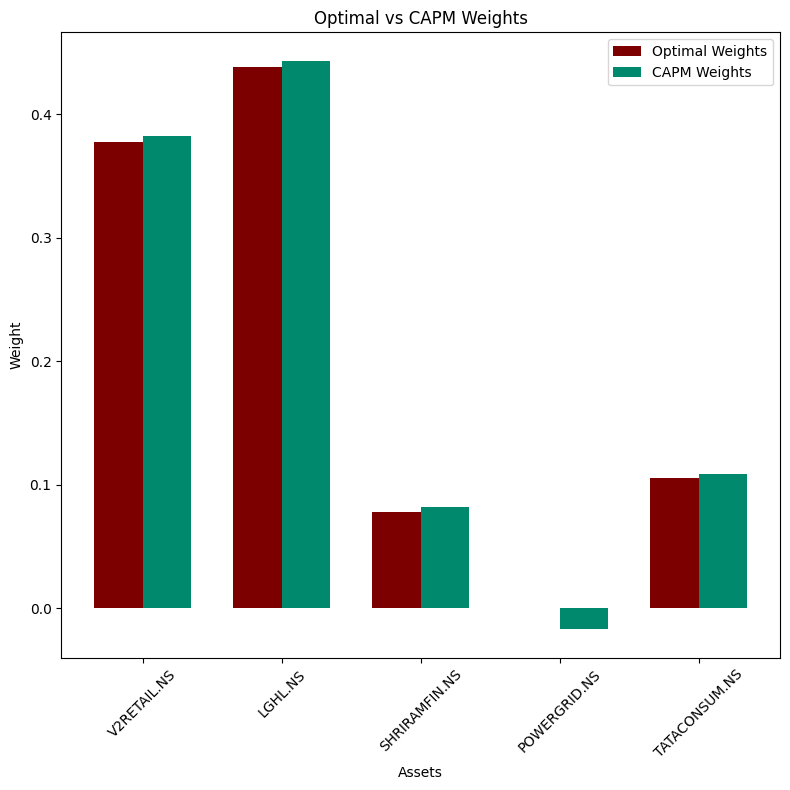


=== Comparing Short-Allowed Portfolio with CAPM Weights ===

=== Comparison with CAPM Weights ===
V2RETAIL.NS: Optimal=0.3826, CAPM=0.3825, Status=Neutral
LGHL.NS: Optimal=0.4435, CAPM=0.4434, Status=Overweight
SHRIRAMFIN.NS: Optimal=0.0820, CAPM=0.0821, Status=Neutral
POWERGRID.NS: Optimal=-0.0170, CAPM=-0.0169, Status=Neutral
TATACONSUM.NS: Optimal=0.1088, CAPM=0.1089, Status=Underweight


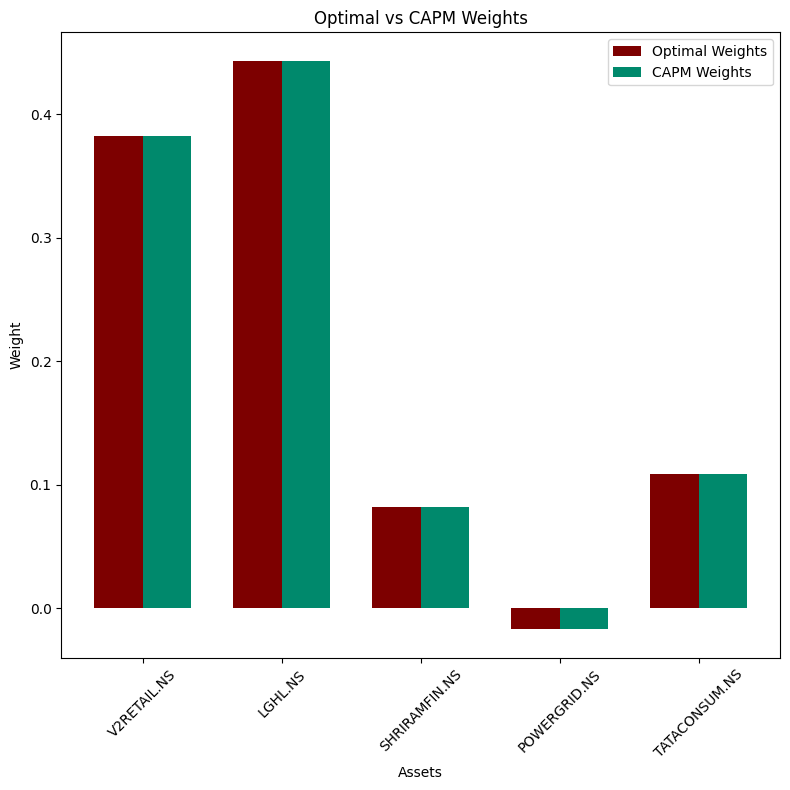


=== Portfolio Statistics (Domestic - No Short Selling) ===

Optimal Weights:
V2RETAIL.NS: 0.3780
LGHL.NS: 0.4385
SHRIRAMFIN.NS: 0.0777
POWERGRID.NS: 0.0000
TATACONSUM.NS: 0.1058

Portfolio Expected Annual Return: 129.6159%
Portfolio Annual Volatility: 28.9359%
Portfolio Sharpe Ratio: 4.2373




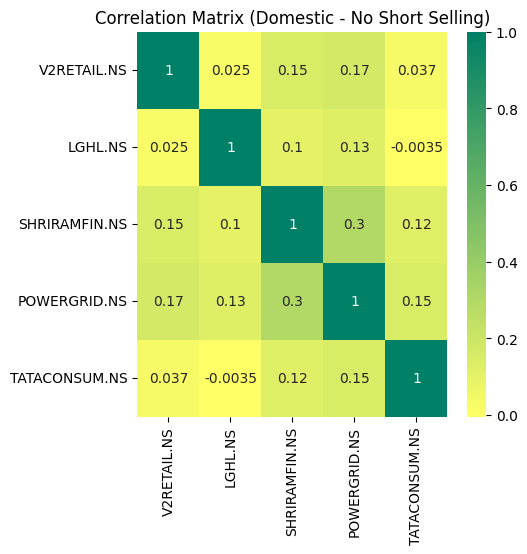




=== Portfolio Statistics (Domestic - With Short Selling) ===

Optimal Weights:
V2RETAIL.NS: 0.3826
LGHL.NS: 0.4435
SHRIRAMFIN.NS: 0.0820
POWERGRID.NS: -0.0170
TATACONSUM.NS: 0.1088

Portfolio Expected Annual Return: 130.7763%
Portfolio Annual Volatility: 29.2067%
Portfolio Sharpe Ratio: 4.2378




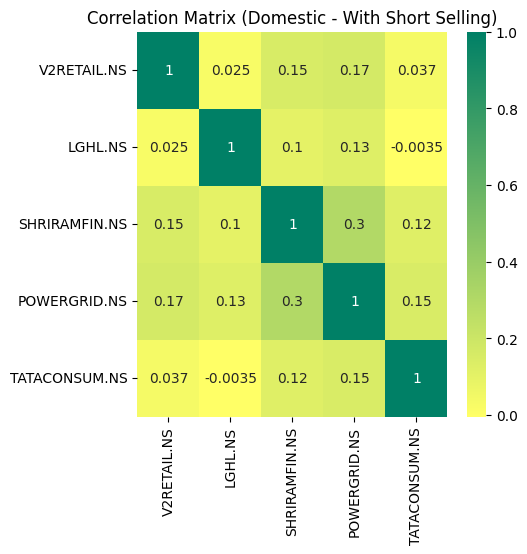

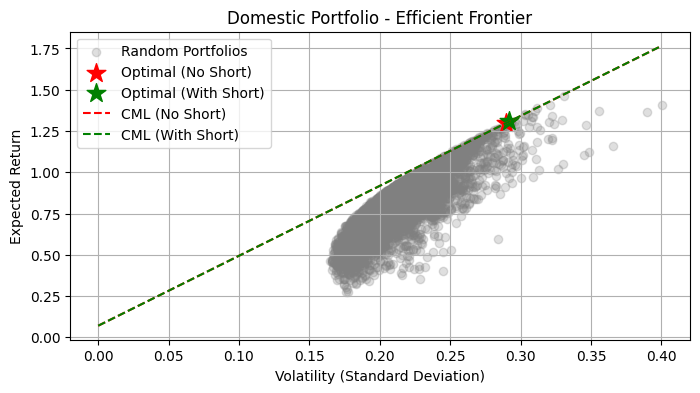

In [22]:
# Domestic Portfolio
# Parameters
start_date = '2023-01-01'
end_date = '2025-02-20'
rf_rate = 7.0044

# Domestic Portfolio
domestic_tickers = ['V2RETAIL.NS', 'LGHL.NS', 'SHRIRAMFIN.NS', 'POWERGRID.NS', 'TATACONSUM.NS']

print("\n=== Analyzing Domestic Portfolio ===")
domestic_optimizer = PortfolioOptimizer(domestic_tickers, rf_rate, start_date, end_date)
domestic_optimizer.fetch_data()

# Optimize domestic portfolio
domestic_no_short = domestic_optimizer.optimize_portfolio('No Short')
domestic_short = domestic_optimizer.optimize_portfolio('Allow Short')

# Display comprehensive statistics for domestic portfolio
domestic_optimizer.display_portfolio_summary(domestic_no_short.x, domestic_short.x)

# Compare both portfolio types with CAPM weights
print("\n=== Comparing No-Short Portfolio with CAPM Weights ===")
domestic_optimizer.compare_with_capm_weights(domestic_no_short.x)
print("\n=== Comparing Short-Allowed Portfolio with CAPM Weights ===")
domestic_optimizer.compare_with_capm_weights(domestic_short.x)

# Display domestic portfolio results
domestic_optimizer.display_stats(domestic_no_short.x, 'Domestic - No Short Selling')
print("\n")
domestic_optimizer.display_stats(domestic_short.x, 'Domestic - With Short Selling')
print("\n")
domestic_optimizer.plot_efficient_frontiers(domestic_short, domestic_no_short,'Domestic Portfolio - Efficient Frontier')

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


=== Analyzing International Portfolio ===



C:\Users\npman\AppData\Local\Temp\ipykernel_26184\2395070402.py:33: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self.returns_data = data.pct_change().dropna()



=== Individual Stock Statistics ===
              Annual Return Annual Volatility Sharpe Ratio Max Drawdown Skewness Kurtosis
V2RETAIL.NS         140.19%            47.75%         2.79      -29.70%     0.59     2.47
LGHL.NS             163.15%            48.52%         3.22      -33.66%     1.11     5.57
SHRIRAMFIN.NS        45.26%            33.17%         1.15      -29.00%     0.55     3.15
POWERGRID.NS         32.40%            27.03%         0.94      -27.82%    -0.65     7.04
TATACONSUM.NS        17.16%            22.01%         0.46      -29.01%     0.25     3.13
^NDX                 35.87%            18.21%         1.58      -13.58%    -0.15     0.51
GC=F                 23.15%            14.24%         1.13      -11.30%    -0.38     1.28

=== Portfolio Summary Statistics ===
                           No Short Selling With Short Selling
Expected Annual Return               82.62%             83.91%
Annual Volatility                    16.38%             16.63%
Sharpe Ratio    

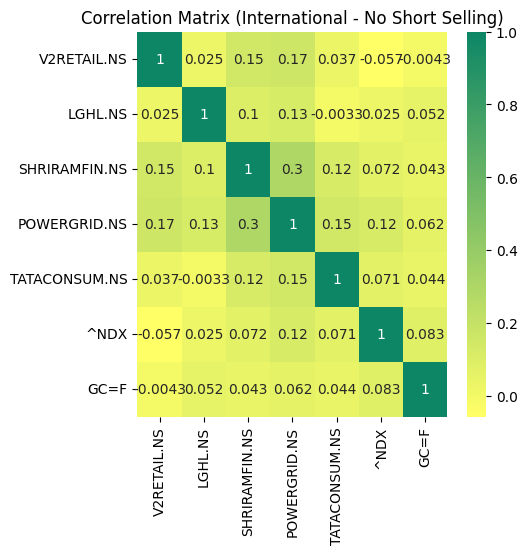




=== Portfolio Statistics (International - With Short Selling) ===

Optimal Weights:
V2RETAIL.NS: 0.2107
LGHL.NS: 0.2276
SHRIRAMFIN.NS: 0.0364
POWERGRID.NS: -0.0394
TATACONSUM.NS: 0.0355
^NDX: 0.3148
GC=F: 0.2145

Portfolio Expected Annual Return: 83.9052%
Portfolio Annual Volatility: 16.6288%
Portfolio Sharpe Ratio: 4.6246




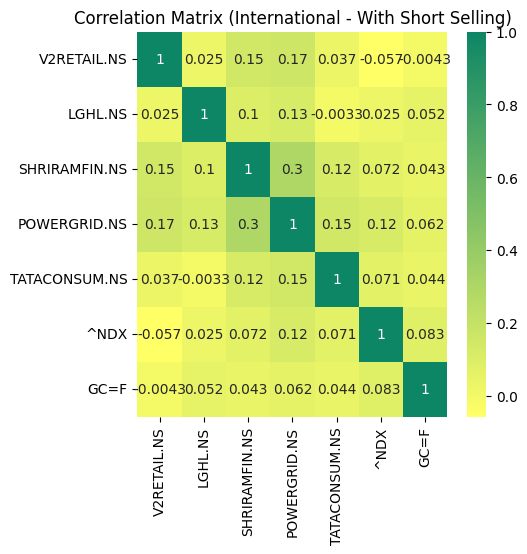

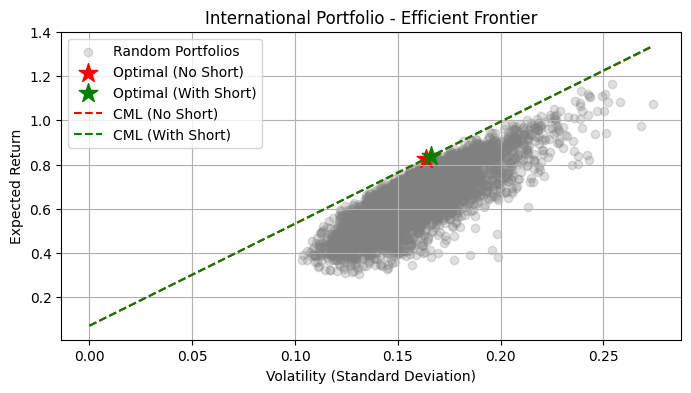

In [23]:
 # International Portfolio (including NASDAQ 100 and Gold)
international_tickers = domestic_tickers + ['^NDX', 'GC=F']

print("\n=== Analyzing International Portfolio ===")
international_optimizer = PortfolioOptimizer(international_tickers, rf_rate, start_date, end_date)
international_optimizer.fetch_data()

# Optimize international portfolio
international_no_short = international_optimizer.optimize_portfolio('No Short')
international_short = international_optimizer.optimize_portfolio('Allow Short')

# Display comprehensive statistics for international portfolio
international_optimizer.display_portfolio_summary(international_no_short.x, international_short.x)

# Display international portfolio results
international_optimizer.display_stats(international_no_short.x, 'International - No Short Selling')
print("\n")
international_optimizer.display_stats(international_short.x, 'International - With Short Selling')
print("\n")
international_optimizer.plot_efficient_frontiers(international_short, international_no_short, 'International Portfolio - Efficient Frontier')